# Feature extraction and EDA 

## 1. Import libraries and explore data

In [1]:
#import libraries
import pandas as pd
import numpy as np
import collections
import re
import sys
import time
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from itertools import islice
import pickle
from sklearn.model_selection import train_test_split

In [2]:
df = pd.DataFrame(pd.read_pickle('df_music'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              5100 non-null   int64  
 1   Song              5100 non-null   object 
 2   Artist            5100 non-null   object 
 3   Year              5100 non-null   int64  
 4   Lyrics            4913 non-null   object 
 5   Source            4913 non-null   float64
 6   Artists clean     5100 non-null   object 
 7   artist_song1      5100 non-null   object 
 8   songs_clean       5100 non-null   object 
 9   artist_song2      5100 non-null   object 
 10  danceability      5083 non-null   object 
 11  energy            5083 non-null   object 
 12  key               5083 non-null   object 
 13  loudness          5083 non-null   object 
 14  mode              5083 non-null   object 
 15  speechiness       5083 non-null   object 
 16  acousticness      5083 non-null   object 


In [4]:
df.shape

(5100, 29)

## 2. Drop songs without or with missing lyrics

In [5]:
# drop rows with missing values

df = df[df.Lyrics != " NA "]
df.dropna( how='any', subset=['Lyrics'], inplace=True)
#reset index
df.reset_index(inplace=True, drop=True)
print("The number of remaining songs is: ", df.shape[0])

The number of remaining songs is:  4897


In [6]:
#remove songs that are instrumental

df=df[df['Lyrics']!='instrumental'] 
df=df[df['Lyrics']!=' instrumental'] 
df=df[df['Lyrics']!=' instrumental '] 
df=df[df['Lyrics']!='instrumental ']
print("The number of remaining songs is: ", df.shape[0])

The number of remaining songs is:  4878


In [7]:
#preserve year and rank variable to match later


## 3. Clean lyrics and tokenize

In [8]:
# clean lyrics - remove punctuation


In [9]:
lyrics=[]

for lyric in df.Lyrics: 
    lyric_string=re.sub('[^A-Za-z]+', ' ', lyric)
    lyrics_string = re.sub('/\s\s+/g', ' ', lyric)
    lyrics.append(lyric_string.lstrip())


In [10]:
# apply wordninja as some lyrics have words crunched together in one string
lyrics_clean=[]
for lyric in lyrics :
    string=wordninja.split(lyric)
    title=""
    for s in string:
        title+=s+" " 
    lyrics_clean.append(title.strip())

In [11]:
#add to df
df['lyrics_clean']=lyrics_clean

In [12]:
#apply lemmatizer and tokenizer
# apply word tokenizer, delete stopwords, and apply lemmatizer
tokens=[]
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for row in lyrics_clean:
    row_tokens=word_tokenize(row)
    filtered_sent = [w for w in row_tokens if not w.lower() in stop_words]
    stemmed = [lemmatizer.lemmatize(word) for word in filtered_sent]
    tokens.append(stemmed)
df['tokens']=tokens

In [13]:
df[['tokens', 'Rank']].to_pickle('df_tokenized')

## 4. Make more features

In [14]:
import warnings
warnings.filterwarnings('ignore')
# Word frequency features
df.unique_words=df.tokens.apply(lambda x: len(set(x) ))
df.total_words=df.tokens.apply(lambda x: len(x) )
df.word_length=df.tokens.apply(lambda x: np.mean([len(word) for word in x]))

#keep only rows where no of words !=0
df=df[df.unique_words!=0]
df.shape

(4831, 31)

In [15]:
# get types of words per song by POS tagging
from nltk.tag import pos_tag
import nltk 
#nltk.download('tagsets')


In [16]:
#list of pos tags per text
def get_pos(text):
    pos=[]
    for i in range(len(text)):
        pos.append(pos_tag(text)[i][1])
    return dict(pd.Series(pos).value_counts())


In [17]:
#pos_count=list(df.tokens.apply(get_pos))

In [18]:
#df_pos_count=pd.DataFrame(pos_count)
#df_pos_count.to_pickle("df_pos_count") # save df

In [20]:
df_pos_count=pd.read_pickle("df_pos_count")

In [21]:
#generate features for word difficulty 

import syllables
import spacy
from textstat.textstat import textstatistics, legacy_round

def syllables_count(word):
    return syllables.estimate(word)
 

# Return total no of Difficult Words in a text (difficult words are those with syllables >= 2)
    # a list of common words)
def difficult_words(text):
    diff_words_set = set()  
    nlp = spacy.load('en_core_web_sm')
    for word in text:
        syllable_count = syllables_count(word)
        if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
    return len(diff_words_set)
 
# Count of  polysyllablic words (if word has more than 3 syllables)

def poly_syllable_count(text):
    count = 0  
    for word in text:
        syllable_count = syllables_count(word)
        if syllable_count >= 3:
            count += 1
    return count

In [22]:
# find number of words per song that are perfect rhymes 
#perfect rhymes: DOG -> COG

from Phyme import Phyme

ph = Phyme()
def get_rhymes(word):
    list_dict=[value for key,value in ph.get_perfect_rhymes(word).items()]
    all_rhymes=[]
    for row in list_dict:
        for word in row:
            all_rhymes.append(word)
    all_rhymes=list(set(all_rhymes))
    return all_rhymes
    
def count_rhymes(text):
    rhyme_count=0
    for word in list(set(text)):
        try:
            all_rhymes=get_rhymes(word) # get list of all words that rhyme
            for x in all_rhymes: # for each of these words, check if it is contained in the lyrics
                if x in text:
                    rhyme_count+=1
                else: 
                    pass
        except:
            pass
    return rhyme_count        

In [23]:
df.shape

(4831, 31)

In [24]:
df['polysyl_count']=df.tokens.apply(poly_syllable_count)
df.shape


(4831, 32)

In [25]:
df['difficult_count']=df.tokens.apply(difficult_words)
df.shape

(4831, 33)

In [26]:
df['count_rhyming_words']=df.tokens.apply(count_rhymes)
df.shape

(4831, 34)

In [28]:
df_pos_count.shape

(4831, 36)

In [29]:
df_all=df.join(df_pos_count, how='inner')

In [30]:
df.shape

(4831, 34)

In [31]:
df.Year=[int(y) for y in df.Year]

In [60]:
#Make bins of chart rank
df['rank_bins']=pd.cut(df.Rank,10, labels=["1-10", "11-20", "21-30", "31-40", "41-50", "51-60","61-70","71-80","81-90","91-100"])


In [70]:
df.to_pickle("df_add_feat") # save df

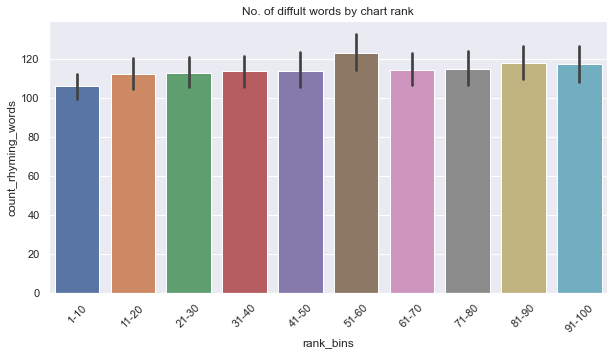

In [69]:
#make plot of no of difficult words by chart rank
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1)
plt.figure(figsize=(10,5))
chart = sns.barplot(x="rank_bins", y="count_rhyming_words", data=df)
labels=chart.get_xticklabels()
chart.set_xticklabels( labels, rotation=45)
chart.set(title='No. of diffult words by chart rank')
None

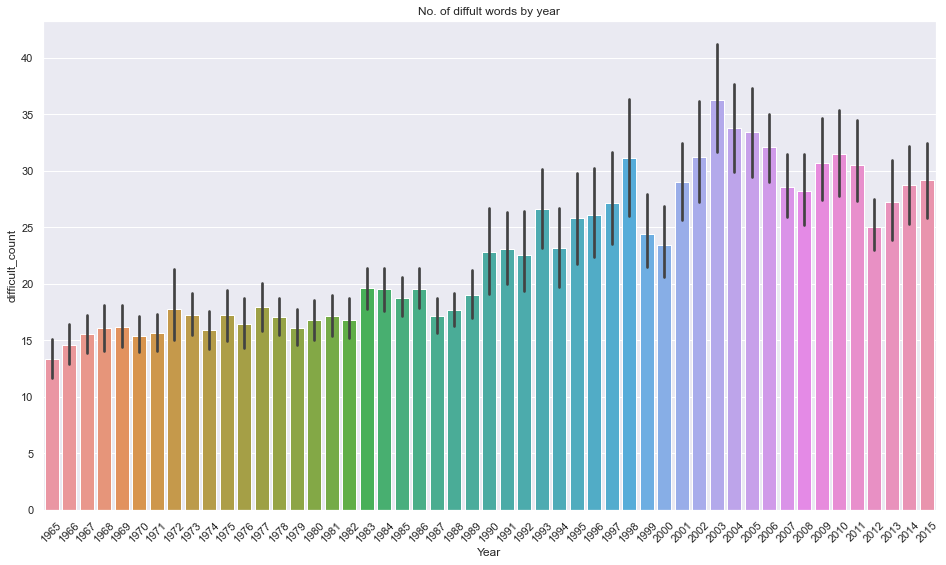

In [39]:
#make plot of no of difficult words by year

sns.set(rc={'figure.figsize':(15,8.27)})
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
chart = sns.barplot(x="Year", y="difficult_count", data=df)
labels=chart.get_xticklabels()
chart.set_xticklabels( labels, rotation=45)
chart.set(title='No. of diffult words by year')
None

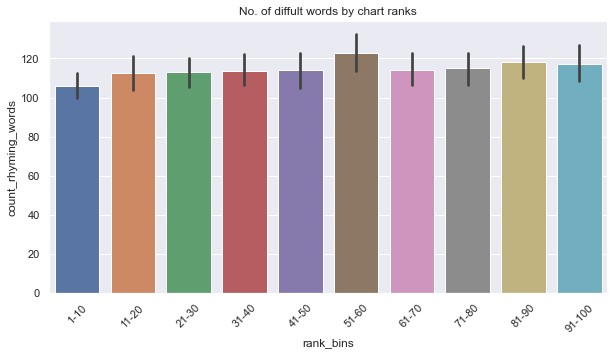

In [66]:
#make plot of no of rhyming words by year ranking

sns.set(rc={'figure.figsize':(10,5)})
sns.set(font_scale = 1)
chart = sns.barplot(x="rank_bins", y="count_rhyming_words", data=df)
labels=chart.get_xticklabels()
chart.set_xticklabels( labels, rotation=45)
chart.set(title='No. of diffult words by chart ranks')
None

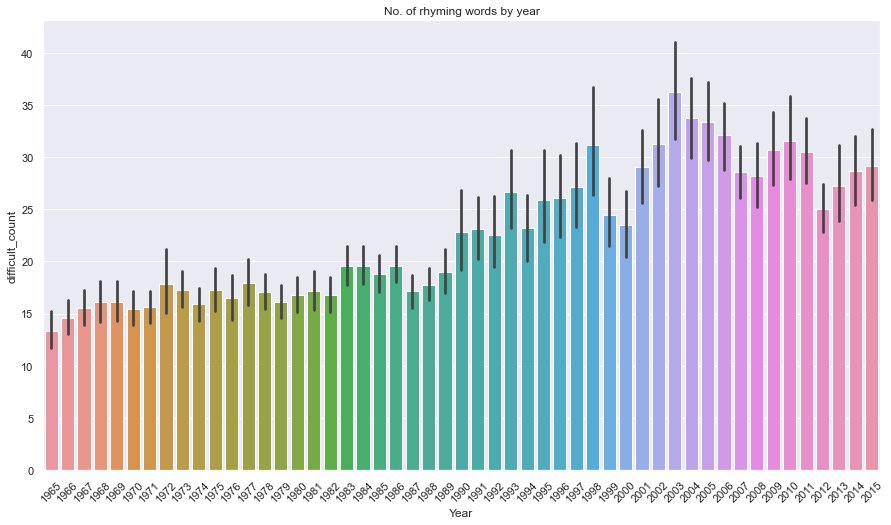

In [68]:
#make plot of no of rhyming words by year ranking
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,8.27)})
sns.set(font_scale = 1)
chart = sns.barplot(x="Year", y="difficult_count", data=df)
labels=chart.get_xticklabels()
chart.set_xticklabels( labels, rotation=45)
chart.set(title='No. of rhyming words by year')
None